Deploying Neural Style Transfer Model Pytorch -> ONNX -> CoreML

Perceptual/Feature Loss: https://arxiv.org/pdf/1603.08155.pdf

In [1]:
import torch; torch.__version__
from fastai.vision import *

In [3]:
# !git clone https://github.com/pytorch/examples/tree/master/fast_neural_style

In [4]:
# # Download pretrained model
# import os
# import zipfile

# from torch.utils.model_zoo import _download_url_to_file


# def unzip(source_filename, dest_dir):
#     with zipfile.ZipFile(source_filename) as zf:
#         zf.extractall(path=dest_dir)


# _download_url_to_file('https://www.dropbox.com/s/lrvwfehqdcxoza8/saved_models.zip?dl=1', './style_transfer/saved_models.zip', None, True)
# unzip('./style_transfer/saved_models.zip', './style_transfer/')

In [2]:
import torch


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

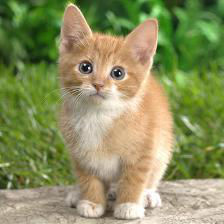

In [3]:
img = open_image('superres/cat224x224.jpg'); img

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img.shape, img.data

In [6]:
def load_model(style='mosaic', device='cuda'):
    style_model = TransformerNet()
    state_dict = torch.load(f'./style_transfer/saved_models/{style}.pth')
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device)
    return style_model

In [7]:
def stylize(content_image, style='mosaic', device='cuda'):
    with torch.no_grad():
        style_model = load_model(style, device)
        output = style_model(content_image.to(device)).detach().cpu()
    return output

In [8]:
def post_process(tensor):
    "take output tensor from model an convert it to Image data"
    tensor = tensor[0].clone().clamp(0, 255).byte()
    return tensor

In [9]:
Path('./style_transfer/saved_models/').ls()

[PosixPath('style_transfer/saved_models/candy.pth'),
 PosixPath('style_transfer/saved_models/udnie.pth'),
 PosixPath('style_transfer/saved_models/rain_princess.pth'),
 PosixPath('style_transfer/saved_models/mosaic.pth')]

torch.Size([3, 224, 224])


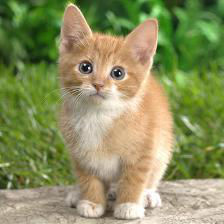

In [10]:
img = open_image('superres/cat224x224.jpg'); print(img.shape); img

In [11]:
# img = open_image('style_transfer/myphoto.jpg'); print(img.shape); img

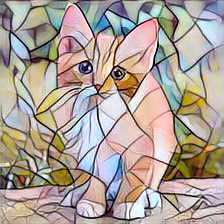

In [12]:
output = stylize(img.data[None, ...]*255, 'mosaic')
Image(post_process(output))

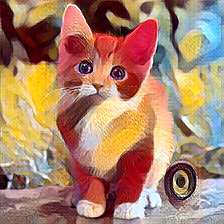

In [13]:
output = stylize(img.data[None, ...]*255, 'candy')
Image(post_process(output))

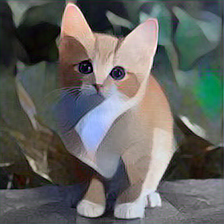

In [14]:
output = stylize(img.data[None, ...]*255, 'udnie')
Image(post_process(output))

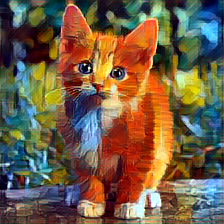

In [15]:
output = stylize(img.data[None, ...]*255, 'rain_princess')
Image(post_process(output))

### PyTorch to ONNX (winML)

packages: `torch.onnx`

In [17]:
import torch.onnx as torch_onnx

In [20]:
import onnx

In [21]:
style_model = load_model('mosaic', 'cuda')
content_image = (img.data[None, ...]*255).cuda()

In [22]:
content_image

tensor([[[[ 35.,  30.,  28.,  ..., 107., 114., 117.],
          [ 32.,  29.,  28.,  ..., 108., 113., 117.],
          [ 31.,  28.,  28.,  ..., 104., 109., 112.],
          ...,
          [182., 184., 175.,  ..., 187., 181., 166.],
          [175., 176., 171.,  ..., 215., 205., 183.],
          [175., 174., 178.,  ..., 218., 207., 181.]],

         [[ 70.,  65.,  64.,  ..., 158., 166., 171.],
          [ 67.,  64.,  64.,  ..., 159., 166., 170.],
          [ 65.,  62.,  62.,  ..., 157., 162., 165.],
          ...,
          [169., 171., 162.,  ..., 174., 168., 153.],
          [162., 163., 158.,  ..., 202., 192., 170.],
          [162., 161., 165.,  ..., 205., 194., 168.]],

         [[ 38.,  32.,  28.,  ...,  91.,  94.,  96.],
          [ 34.,  31.,  28.,  ...,  92.,  94.,  98.],
          [ 32.,  27.,  27.,  ...,  89.,  90.,  93.],
          ...,
          [150., 152., 143.,  ..., 158., 152., 137.],
          [143., 144., 139.,  ..., 186., 176., 154.],
          [143., 142., 146.,  ...

In [23]:
torch_output = onnx._export(style_model, content_image, './style_transfer/mosaic_model_native.onnx').cpu()

AttributeError: module 'onnx' has no attribute '_export'

In [46]:
torch_output = torch.onnx._export(style_model, content_image, './style_transfer/mosaic_model.onnx').cpu()

In [47]:
torch_output

tensor([[[[ 90.2739,  88.9466,  87.6355,  ..., 122.5455, 122.1099, 112.7354],
          [109.6347, 108.6786, 113.4326,  ..., 163.1519, 169.7958, 164.3148],
          [111.9682, 114.1988, 106.3429,  ..., 160.3271, 166.5550, 158.5300],
          ...,
          [172.2892, 158.1845, 129.8492,  ..., 164.9546, 167.0591, 155.0690],
          [192.0739, 174.9940, 156.7012,  ..., 202.0420, 197.7174, 180.1271],
          [193.8741, 173.1942, 161.1302,  ..., 198.9011, 196.6697, 182.4818]],

         [[ 97.7691,  96.4688,  91.9368,  ..., 139.3205, 134.8130, 129.6448],
          [ 88.2277,  84.3098,  88.0134,  ..., 160.3486, 160.6035, 157.6820],
          [110.5830, 110.5238, 101.3378,  ..., 165.9858, 168.0467, 163.8826],
          ...,
          [175.5733, 167.1330, 134.5354,  ..., 168.1682, 163.8403, 155.0592],
          [173.3594, 157.3311, 139.2166,  ..., 179.9925, 174.0467, 165.2914],
          [174.3765, 154.9846, 141.4879,  ..., 171.4030, 166.9485, 158.0755]],

         [[ 99.0982, 101.2760,

### ONNX to TF

packages: `onnx`, `onnx_tf`, `protobuf`

In [23]:
!pip install -U protobuf

    100% |████████████████████████████████| 1.2MB 22.3MB/s ta 0:00:01
  Found existing installation: protobuf 3.4.1
    Uninstalling protobuf-3.4.1:
      Successfully uninstalled protobuf-3.4.1


In [26]:
import torch.onnx as onnx

In [27]:
from onnx_tf.backend import prepare

onnx_model = torch.onnx.load("./style_transfer/mosaic_model.onnx")  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")  # export the model

TypeError: __new__() got an unexpected keyword argument 'serialized_options'

In [ ]:
from onnx_

### ONNX to CAFFE2

In [48]:
import onnx
import caffe2.python.onnx.backend as onnx_caffe2_backend

# content image shape 224, 224, 3
model = onnx.load('./style_transfer/mosaic_model.onnx')
prepared_backend = onnx_caffe2_backend.prepare(model, device='CUDA' if torch.cuda.is_available() else 'CPU')
inp = {model.graph.input[0].name: content_image.cpu().numpy().astype(np.float32)}
caffe2_output = prepared_backend.run(inp)[0]

CUDA operators do not support 64-bit doubles, please use arr.astype(np.float32) or np.int32 for ints. Blob: input.1 type: float64


In [49]:
np.testing.assert_almost_equal(torch_output.data.cpu().numpy(), caffe2_output, decimal=2)
print("Success, PyTorch and Caffe2 outputs match!")

Success, PyTorch and Caffe2 outputs match!


### Caffe2 to Protobuf for Android

Using emulator

In [51]:
# extract the workspace and the model proto from the internal representation
c2_workspace = prepared_backend.workspace
c2_model = prepared_backend.predict_net

# Now import the caffe2 mobile exporter
from caffe2.python.predictor import mobile_exporter

# call the Export to get the predict_net, init_net. These nets are needed for running things on mobile
init_net, predict_net = mobile_exporter.Export(c2_workspace, c2_model, c2_model.external_input)

# Let's also save the init_net and predict_net to a file that we will later use for running them on mobile
with open('./style_transfer/mosaic_init_net.pb', "wb") as fopen:
    fopen.write(init_net.SerializeToString())
with open('./style_transfer/mosaic_predict_net.pb', "wb") as fopen:
    fopen.write(predict_net.SerializeToString())

In [54]:
# Some standard imports
from caffe2.proto import caffe2_pb2
from caffe2.python import core, net_drawer, net_printer, visualize, workspace, utils

# Let's run the mobile nets that we generated above so that caffe2 workspace is properly initialized
workspace.RunNetOnce(init_net)
workspace.RunNetOnce(predict_net)

# Caffe2 has a nice net_printer to be able to inspect what the net looks like and identify
# what our input and output blob names are.
print(net_printer.to_string(predict_net))

net_drawer will not run correctly. Please install the correct dependencies.
torch-jit-export_predict = core.Net('torch-jit-export_predict')
torch-jit-export_predict.PadImage(['input.1'], ['63'], pads=[4, 4, 4, 4], mode='reflect')
torch-jit-export_predict.Conv(['63', '1', '2'], ['64'], strides=[1, 1], pads=[0, 0, 0, 0], kernels=[9, 9], group=1, dilations=[1, 1])
torch-jit-export_predict.InstanceNorm(['64', '3', '4'], ['65'], epsilon=9.999999747378752e-06)
torch-jit-export_predict.Relu(['65'], ['66'])
torch-jit-export_predict.PadImage(['66'], ['67'], pads=[1, 1, 1, 1], mode='reflect')
torch-jit-export_predict.Conv(['67', '5', '6'], ['68'], strides=[2, 2], pads=[0, 0, 0, 0], kernels=[3, 3], group=1, dilations=[1, 1])
torch-jit-export_predict.InstanceNorm(['68', '7', '8'], ['69'], epsilon=9.999999747378752e-06)
torch-jit-export_predict.Relu(['69'], ['70'])
torch-jit-export_predict.PadImage(['70'], ['71'], pads=[1, 1, 1, 1], mode='reflect')
torch-jit-export_predict.Conv(['71', '9', '10'], [

In [63]:
# Now, let's also pass in the resized cat image for processing by the model.
workspace.FeedBlob("input.1", content_image.cpu().data.numpy().astype(np.float32))

# run the predict_net to get the model output
workspace.RunNetOnce(predict_net)

# Now let's get the model output blob
caffe2_proto_output = workspace.FetchBlob("128")

In [65]:
np.testing.assert_almost_equal(torch_output.data.cpu().numpy(), caffe2_proto_output, decimal=2)
print("Success, PyTorch and Caffe2 Protobuf outputs match!")

Success, PyTorch and Caffe2 Protobuf outputs match!


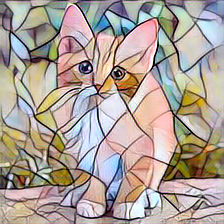

In [72]:
Image(post_process(tensor(caffe2_proto_output)))

### ONNX to CoreML for IOS

In [30]:
# ! pip install coremltools onnx-coreml
# !pip install PyHamcrest typing-extensions
# !pip install netron

In [24]:
# visually inspect model to find input and output names
import netron
netron.start('style_transfer/mosaic_model.onnx', port=9999)


Stopping http://:9999
Serving 'style_transfer/mosaic_model.onnx' at http://:9999


In [75]:
import onnx_coreml;

In [29]:
import sys
from onnx import onnx_pb
from onnx_coreml import convert

model_file = open('./style_transfer/mosaic_model.onnx', 'rb')
model_proto = onnx_pb.ModelProto()
model_proto.ParseFromString(model_file.read())
coreml_model = convert(model_proto, image_input_names=['input.1'], image_output_names=['128'])
coreml_model.save('./style_transfer/mosaic_model.mlmodel')

1/64: Converting Node Type Pad
2/64: Converting Node Type Conv
3/64: Converting Node Type InstanceNormalization
4/64: Converting Node Type Relu
5/64: Converting Node Type Pad
6/64: Converting Node Type Conv
7/64: Converting Node Type InstanceNormalization
8/64: Converting Node Type Relu
9/64: Converting Node Type Pad
10/64: Converting Node Type Conv
11/64: Converting Node Type InstanceNormalization
12/64: Converting Node Type Relu
13/64: Converting Node Type Pad
14/64: Converting Node Type Conv
15/64: Converting Node Type InstanceNormalization
16/64: Converting Node Type Relu
17/64: Converting Node Type Pad
18/64: Converting Node Type Conv
19/64: Converting Node Type InstanceNormalization
20/64: Converting Node Type Add
21/64: Converting Node Type Pad
22/64: Converting Node Type Conv
23/64: Converting Node Type InstanceNormalization
24/64: Converting Node Type Relu
25/64: Converting Node Type Pad
26/64: Converting Node Type Conv
27/64: Converting Node Type InstanceNormalization
28/64: 

### Download model to local Macbook and test

In [31]:
from IPython.display import FileLink

In [32]:
FileLink("./style_transfer/mosaic_model.mlmodel")

/home/ubuntu/on-device/pytorch/style_transfer/mosaic_model.mlmodel